In [1]:
import pandas as pd
from validation import gen_query_gallery_pairs
from validation import val_inference, get_ground_truth, calc_metrics

import torch
import pandas as pd

from collections import defaultdict
from torch.nn import functional as F
from oml import datasets as d
from oml.inference import inference
from oml.metrics import calc_retrieval_metrics_rr

from oml.models import ViTExtractor
from oml.registry import get_transforms_for_pretrained
from oml.retrieval import RetrievalResults, AdaptiveThresholding

from validation import gen_query_gallery_pairs, val_inference, calc_metrics, print_metrics
from config import OML_EXTRACTOR, OML_MODEL_NAME

/kaggle/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df_val = pd.read_csv("reorganized_val.csv")
df_val

,label,path,split,is_query,is_gallery
0,10000,data/train/images/000000/6.jpg,validation,True,False
1,10000,data/train/images/000000/7.jpg,validation,False,True
2,10000,data/train/images/000000/8.jpg,validation,False,True
3,10001,data/train/images/000001/8.jpg,validation,False,True
4,10001,data/train/images/000001/9.jpg,validation,False,True
...,...,...,...,...,...
22983,9997,data/train/images/009997/8.jpg,validation,False,True
22984,19998,data/train/images/009998/8.jpg,validation,False,True
22985,19998,data/train/images/009998/9.jpg,validation,False,True
22986,19999,data/train/images/009999/6.jpg,validation,True,False


In [7]:
model = OML_EXTRACTOR[OML_MODEL_NAME].from_pretrained(OML_MODEL_NAME)
state_dict = torch.load(
    f"./curr_best_model_weights/{OML_MODEL_NAME}/model.pth", map_location="cuda"
)
model.load_state_dict(state_dict)
model = model.to("cuda").eval()

transform, _ = get_transforms_for_pretrained(OML_MODEL_NAME)

df_val = gen_query_gallery_pairs(df_val)
df_gt_val = get_ground_truth(df_val)

val = d.ImageQueryGalleryLabeledDataset(df_val, transform=transform)

/kaggle/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
MAP@10: 100%|██████████| 10093/10093 [00:00<00:00, 12501.98it/s]
/kaggle/venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1171: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


ValueError: All-NaN slice encountered

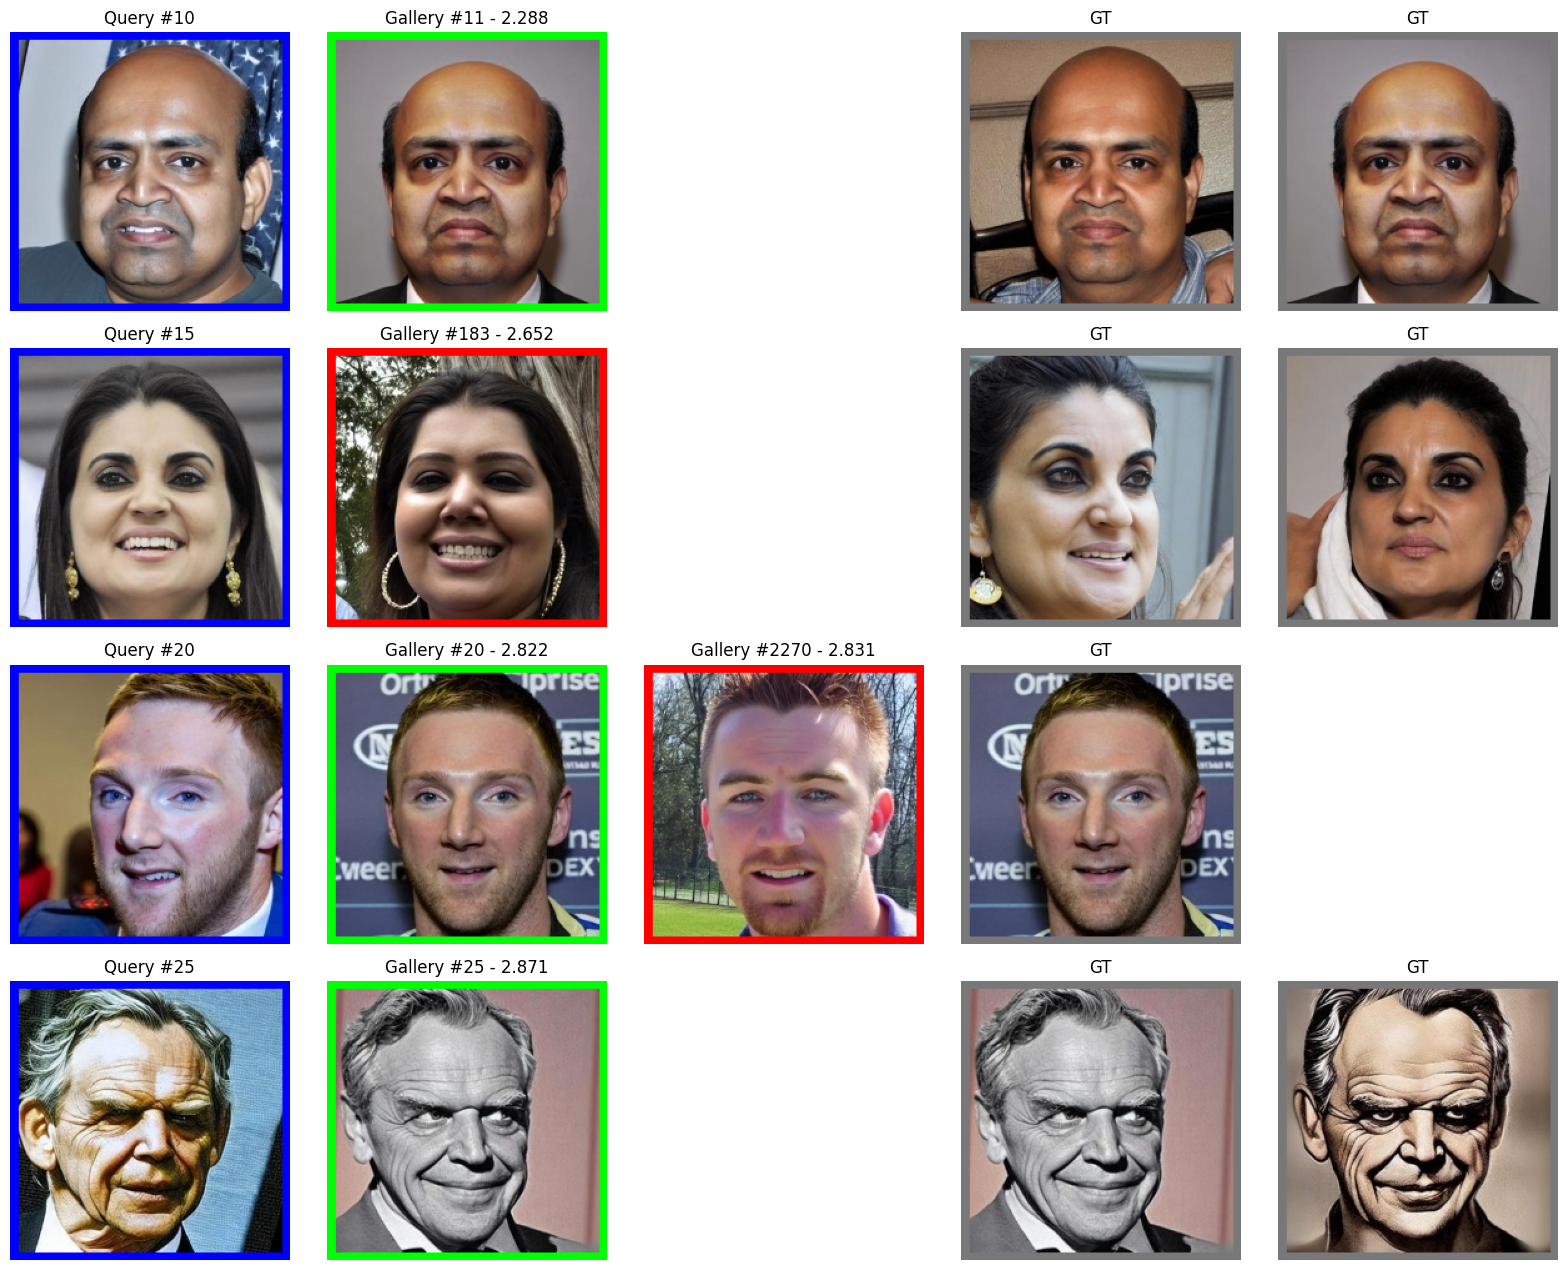

In [8]:
embeddings, df_pred_val = val_inference(model, val, df_val)
rank_metrics, eer_metric = calc_metrics(
    embeddings, df_gt_val, df_pred_val, val
)
print_metrics(rank_metrics, eer_metric)

# restart this line